<a href="https://colab.research.google.com/github/Bmartins25/Pratica01_UFJF_Mestrado/blob/main/Panor%C3%A2mica_2_Detalhada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys

In [97]:
img1 = cv2.imread("image1.jpg")
img2 = cv2.imread("image2.jpg")

In [98]:
def registration(img1,img2):
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    matcher = cv2.BFMatcher()
    raw_matches = matcher.knnMatch(des1, des2, k=2)
    good_points = []
    good_matches=[]

    for m1, m2 in raw_matches:
        if m1.distance < ratio * m2.distance:
            good_points.append((m1.trainIdx, m1.queryIdx))
            good_matches.append([m1])
    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
    cv2.imwrite('matching.jpg', img3)

    if len(good_points) > min_match:
        image1_kp = np.float32(
            [kp1[i].pt for (_, i) in good_points])
        image2_kp = np.float32(
            [kp2[i].pt for (i, _) in good_points])
        H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
    return H





In [99]:
img3 = cv2.imread("matching.jpg")

In [100]:
def create_mask(img1,img2,version):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 +width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version== 'left_image':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    return cv2.merge([mask, mask, mask])

In [101]:
def stitching(img1,img2):
    H = registration(img1,img2)
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 +width_img2

    panorama1 = np.zeros((height_panorama, width_panorama, 3))
    mask1 = create_mask(img1,img2,version='left_image')
    panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
    panorama1 *= mask1
    mask2 = create_mask(img1,img2,version='right_image')
    panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
    result=panorama1+panorama2

    rows, cols = np.where(result[:, :, 0] != 0)
    min_row, max_row = min(rows), max(rows) + 1
    min_col, max_col = min(cols), max(cols) + 1
    final_result = result[min_row:max_row, min_col:max_col, :]
    return final_result

# Parameters
ratio = 0.85
min_match = 10
sift = cv2.xfeatures2d.SIFT_create()
smoothing_window_size = 800


In [102]:

# Main
if __name__ == '__main__':
    img1 = cv2.imread('image1.jpg')      # read image1 path from command line
    img2 = cv2.imread('image2.jpg')      # read image2 path from command line
    output = stitching(img1,img2)
    cv2.imwrite('panorama.jpg', output)

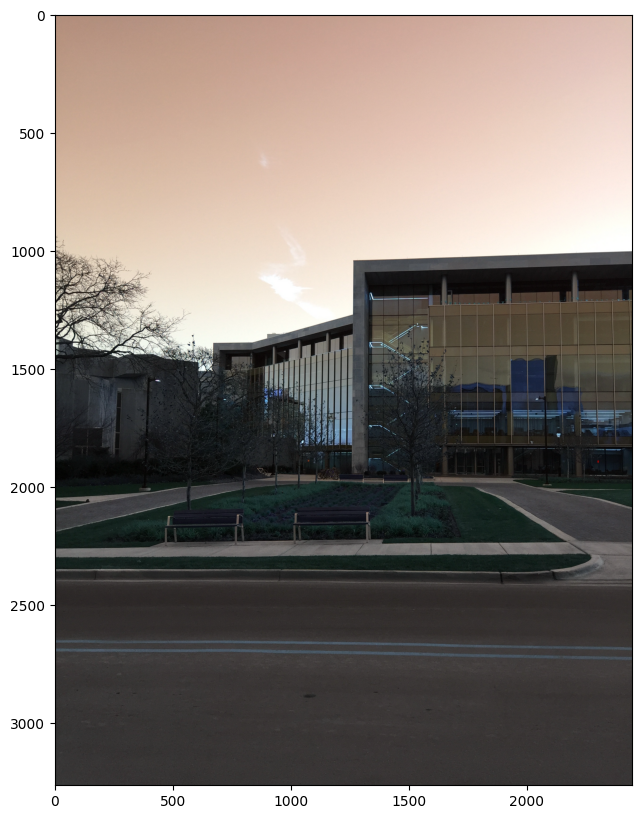

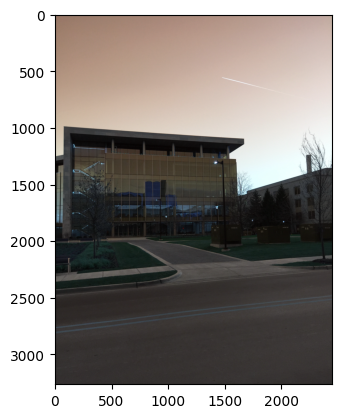

(<matplotlib.image.AxesImage at 0x794fea739d50>, None)

In [103]:
plt.figure(figsize=(15,10))
plt.imshow(img1),plt.show()
plt.imshow(img2),plt.show()


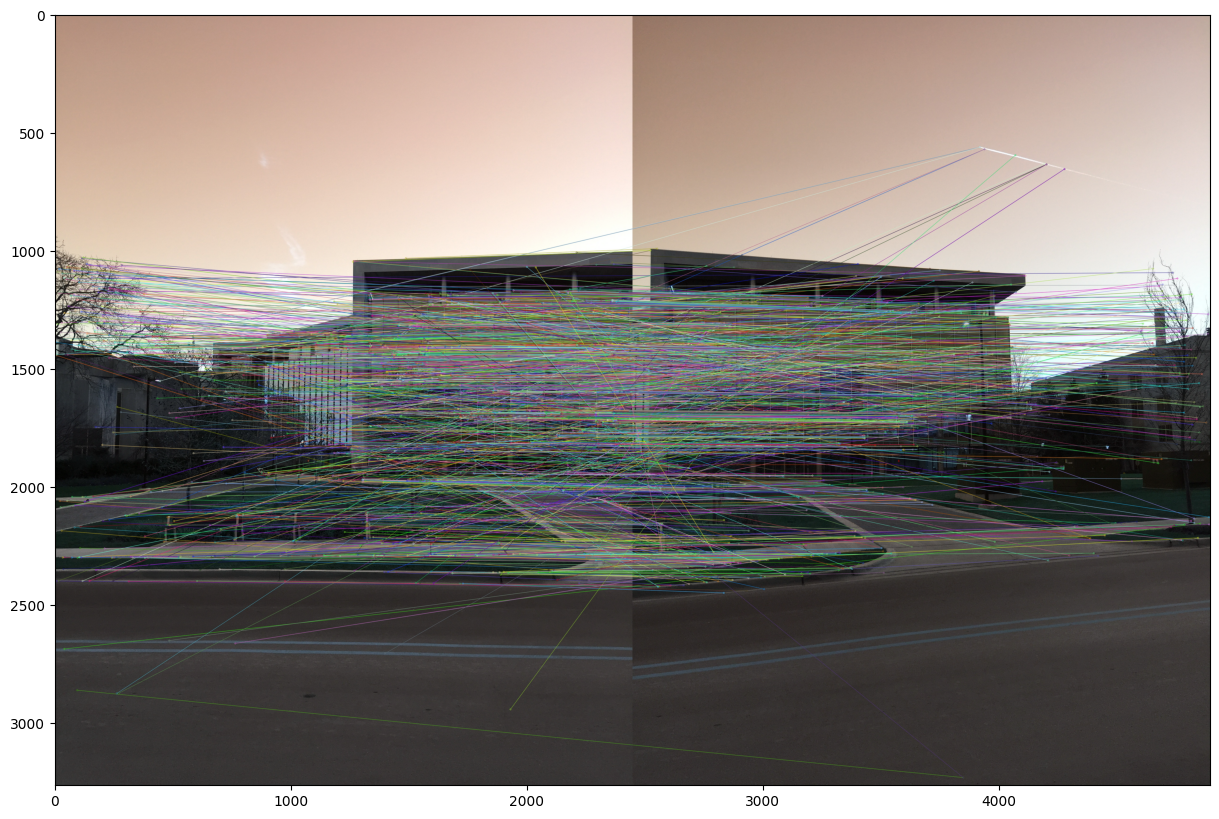

In [104]:
plt.figure(figsize=(15,10))
plt.imshow(img3)

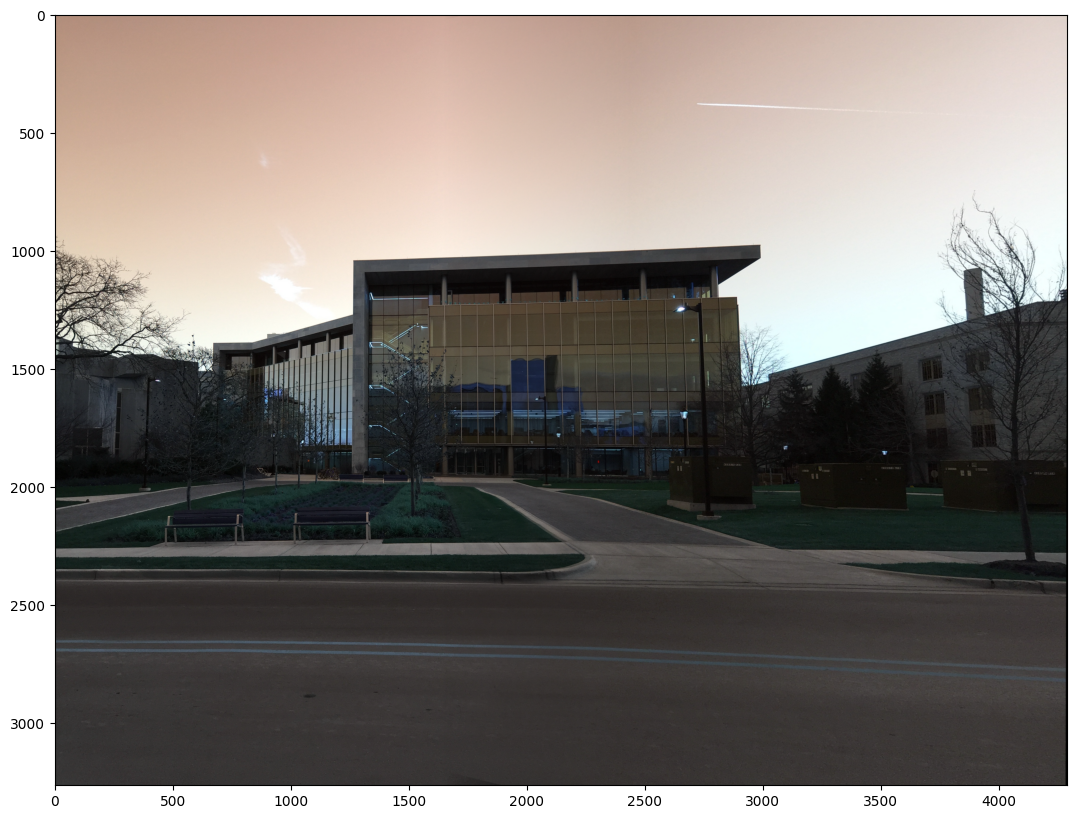

In [105]:
plt.figure(figsize=(15,10))
plt.imshow(output.astype('uint8'))